Оригинальный туториал:<br>
https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [5]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

In [16]:
model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [32]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 59
Total number of feature channels: 7548


In [57]:
print('Layers:',)
for idx, l in enumerate(layers):
    print(str(idx+1)+'. '+l.split('/')[1], '; features: ', int(graph.get_tensor_by_name(l+':0').get_shape()[-1]))

Layers:
1. conv2d0_pre_relu ; features:  64
2. conv2d1_pre_relu ; features:  64
3. conv2d2_pre_relu ; features:  192
4. mixed3a_1x1_pre_relu ; features:  64
5. mixed3a_3x3_bottleneck_pre_relu ; features:  96
6. mixed3a_3x3_pre_relu ; features:  128
7. mixed3a_5x5_bottleneck_pre_relu ; features:  16
8. mixed3a_5x5_pre_relu ; features:  32
9. mixed3a_pool_reduce_pre_relu ; features:  32
10. mixed3b_1x1_pre_relu ; features:  128
11. mixed3b_3x3_bottleneck_pre_relu ; features:  128
12. mixed3b_3x3_pre_relu ; features:  192
13. mixed3b_5x5_bottleneck_pre_relu ; features:  32
14. mixed3b_5x5_pre_relu ; features:  96
15. mixed3b_pool_reduce_pre_relu ; features:  64
16. mixed4a_1x1_pre_relu ; features:  192
17. mixed4a_3x3_bottleneck_pre_relu ; features:  96
18. mixed4a_3x3_pre_relu ; features:  204
19. mixed4a_5x5_bottleneck_pre_relu ; features:  16
20. mixed4a_5x5_pre_relu ; features:  48
21. mixed4a_pool_reduce_pre_relu ; features:  64
22. mixed4b_1x1_pre_relu ; features:  160
23. mixed4b_3

In [102]:
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap
    
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

    
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)
    

def render_deepdream(t_obj, img0=img_noise, iter_n=10, step=1.5, octave_n=2, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(img/255.0)

In [95]:
print('Images:\n')
for imgfile in os.listdir('./images/'):
    print('images/'+imgfile)

Images:

images/mailru.jpg
images/pilatus800.jpg


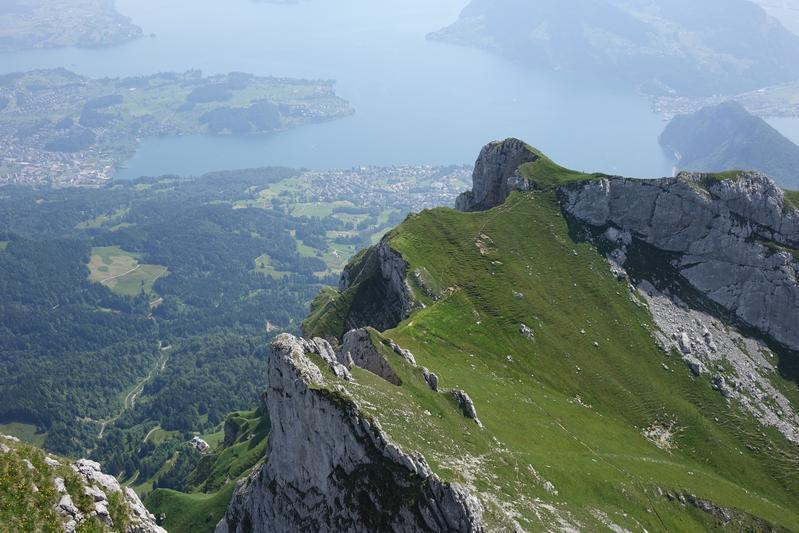

In [99]:
img0 = PIL.Image.open('./images/pilatus800.jpg')
#img0 = PIL.Image.open('images/mailru.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

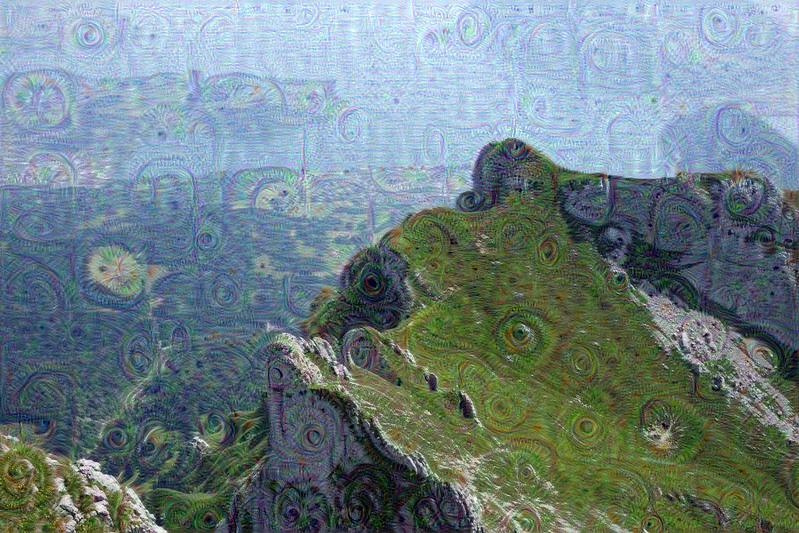

Chosen random layer:  mixed4c_pool_reduce_pre_relu (32 of 59)
Chosen random feature from this layer: 52


In [103]:
rand_layer_num = np.random.randint(len(layers))
layer = layers[rand_layer_num].split('/')[1]
feature = np.random.randint(int(graph.get_tensor_by_name('import/'+layer+':0').get_shape()[-1]))
render_deepdream(T(layer)[:,:,:,feature], img0)
print('Chosen random layer: ', layer, '(%d of %d)'% (rand_layer_num, len(layers)))
print('Chosen random feature from this layer:', feature)